This notebook examines correlations between sky factors (moon distance, moon illumination, seeing, zero-point magnitude, limiting magnitude, and skysig) and the number of "good" (R/B > 0.6) object detections per exposure.

In [1]:
# Logging in and connecting to the database
import psycopg2
import psycopg2.extras
import getpass

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl

# Finding moon separation
from astropy.time import Time
from astropy.coordinates import get_moon, GCRS
import astropy.units as u

# Math
import numpy as np
import pandas as pd

In [2]:
font = {'size'   : 15}

mpl.rc('font', **font)

# For the three-panel figures, the dimensions of each row
figwidth = 15
figheight = 4
lfs = 13 # legend font size

dotsize = 50 # Marker size for scatterplots
a = 0.2 # Alpha value

In [3]:
dbuser = input("DB User: ")
dbpasswd = getpass.getpass("DB Password: ")

db = psycopg2.connect(f"dbname='decat' user='{dbuser}' password='{dbpasswd}' host='decatdb.lbl.gov'")

db.autocommit = True # Makes the computer more forgiving about SQL syntax errors

cursor = db.cursor( cursor_factory = psycopg2.extras.DictCursor )

DB User:  kennedyt
DB Password:  ············


In [4]:
def rm_dupes( arr, ecols=None ):
    """
    Removes duplicate rows from a numpy array. Has functionality to exclude some column(s) from the duplicate-finding process.
    For the purposes of these notebooks, that should be the index of the object ID column, if your array includes it, and left blank
    if not. For best results, make sure your array includes candidate id, R/B score, and something to tie it to a specific 
    exposure (fnm or eid)
    
    Takes:
    arr : the original array with some duplicate rows
    ecols : index/indices of excluded columns. NOTE: no matter what this index is, it will be the first column of res
    
    Returns:
    res : the original array with the duplicate rows removed
    """
    if ecols == None:
        dupes = arr
    else:
        dupes = np.delete(arr, ecols, axis=0)
    dupes = np.array( [" ".join(i) for i in dupes.transpose()] )
    unique, ind = np.unique( dupes, return_index=True )
    uarr = np.array( [ i.split(" ") for i in unique ] ).transpose()
    if ecols == None:
        res = uarr
    else:
        res = np.append( [arr[ecols][ind]], uarr, axis=0 )
    print( "%s duplicates removed" % ( len( arr[0] ) - len( res[0] ) ) )
    return res

#### How does moon illumination affect the number of good detections per image? (uses lookup table 'moondata.txt') (COSMOS & ELIAS)

In [5]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery2 = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.candidate_id, e.filename, e.filter, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

ELIASillum = np.array( cursor.fetchall() ).transpose()

In [6]:
# Removing duplicate objects
moonquery2 = rm_dupes(moonquery2)
ELIASillum = rm_dupes(ELIASillum)

2002 duplicates removed
18 duplicates removed


In [7]:
# truncate filenames to match lookup table format
fnms = [ moonquery2[1][i][:21] for i in range( len( moonquery2[1] ) ) ]

# count the number of objects in each image (obsperimg) and create a mask to select the data for each of those exposures only once (index)
cands, index, objsperimg = np.unique( moonquery2[1], return_index=True, return_counts=True )

# load in the lookup table
moonlt = np.loadtxt( "moondata.txt", dtype=np.str ).transpose()

fnms = np.array( fnms )[index]

# create an array of moon illuminations by matching the filenames in the query result to the filenames in the lookup table
illum = np.ones( len( fnms ) )
for i in range( len( fnms ) ):
    illum[i] = moonlt[2][ np.where( fnms[i] == moonlt[0] )[0] ]

In [8]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [9]:
# Eliminate objects from non-standard images
filters = np.array( moonquery2[2] )[index]

gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
filters = filters[grimsk]
illum = illum[grimsk]
objsperimg = objsperimg[grimsk]

In [10]:
# Create masks for different filters
gmsk = np.where( filters=='g' )[0]
rmsk = np.where( filters=='r' )[0]
imsk = np.where( filters=='i' )[0]

# Apply those filters and spread the data points out a bit
gill, opig_ill = illum[gmsk]+0.025*np.random.rand(len(gmsk)), objsperimg[gmsk] 
rill, opir_ill = illum[rmsk]+0.025*np.random.rand(len(rmsk)), objsperimg[rmsk] 
iill, opii_ill = illum[imsk]+0.025*np.random.rand(len(imsk)), objsperimg[imsk] 

In [11]:
# truncate filenames to match lookup table format
fnms = [ ELIASillum[1][i][:21] for i in range( len( ELIASillum[1] ) ) ]

# count the number of objects in each image (obsperimg) and create a mask to select the data for each of those exposures only once (index)
cands, index, objsperimg = np.unique( ELIASillum[1], return_index=True, return_counts=True )

# load in the lookup table
moonlt = np.loadtxt( "moondata.txt", dtype=np.str ).transpose()

fnms = np.array( fnms )[index]

# create an array of moon illuminations by matching the filenames in the query result to the filenames in the lookup table
illum = np.ones( len( fnms ) )
for i in range( len( fnms ) ):
    illum[i] = moonlt[2][ np.where( fnms[i] == moonlt[0] )[0] ]

In [12]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [13]:
# Eliminate objects from non-standard images
filters = np.array( ELIASillum[2] )[index]

gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
filters = filters[grimsk]
illum = illum[grimsk]
objsperimg = objsperimg[grimsk]

In [14]:
# Create masks for different filters
gmsk = np.where( filters=='g' )[0]
rmsk = np.where( filters=='r' )[0]
imsk = np.where( filters=='i' )[0]

Egill, Eopig_ill = illum[gmsk]+0.025*np.random.rand(len(gmsk)), objsperimg[gmsk] 
Erill, Eopir_ill = illum[rmsk]+0.025*np.random.rand(len(rmsk)), objsperimg[rmsk] 
Eiill, Eopii_ill = illum[imsk]+0.025*np.random.rand(len(imsk)), objsperimg[imsk] 

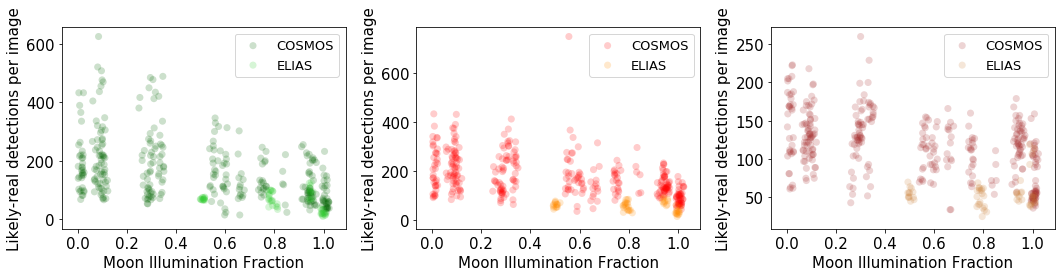

In [15]:
# Plotting it
fig, ax = plt.subplots(1,3, figsize = (figwidth,figheight))

ax[0].scatter( gill, opig_ill, color='darkgreen', label='COSMOS', s=dotsize, alpha=a, edgecolors='none' )
ax[0].scatter( Egill, Eopig_ill, color='limegreen', label='ELIAS', s=dotsize, alpha=a, edgecolors='none' )
ax[1].scatter( rill, opir_ill, color='red', label='COSMOS', s=dotsize, alpha=a, edgecolors='none' )
ax[1].scatter( Erill, Eopir_ill, color='darkorange', label='ELIAS', s=dotsize, alpha=a, edgecolors='none' )
ax[2].scatter( iill, opii_ill, color='brown', label='COSMOS', s=dotsize, alpha=a, edgecolors='none' )
ax[2].scatter( Eiill, Eopii_ill, color='peru', label='ELIAS', s=dotsize, alpha=a, edgecolors='none' )

for i in ax:
    i.set_xlabel( 'Moon Illumination Fraction' )
    i.set_ylabel( 'Likely-real detections per image' )
    i.legend(fontsize=lfs)
plt.tight_layout()
plt.savefig("./images/moonillVopi_COSMOS");

#### How does seeing affect the number of good detections? (COSMOS & ELIAS)

In [16]:
query = ( 'SELECT o.id, e.filename, s.seeing, e.filter, e.id, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

seeingquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.id, e.filename, s.seeing, e.filter, e.id, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

Eseeingquery = np.array( cursor.fetchall() ).transpose()

In [17]:
seeingquery = rm_dupes(seeingquery, 0)
Eseeingquery = rm_dupes(Eseeingquery, 0)

2002 duplicates removed
18 duplicates removed


In [18]:
expids = seeingquery[4].astype(np.int)
seeing = seeingquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
expids_unique, indices, objperimg = np.unique( seeingquery[4], return_counts=True, return_index=True )


# Find the average seeing for each exposure
seeing = np.array( [np.mean( seeing[np.where( expids == i )[0]] ) for i in expids_unique.astype(float)] )

In [19]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
exp, indices, objperimg = np.unique( seeingquery[4], return_counts=True, return_index=True )
filters = np.array(seeingquery[3][indices])
fnms = seeingquery[1][indices]

In [20]:
# truncate filenames to match lookup table format
fnms = [fnms[i][:21] for i in range(len(fnms))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [21]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
seeing = seeing[grimsk]
objperimg = objperimg[grimsk]
filters = filters[grimsk]
len(grimsk)

1038

In [22]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

gsee, opig_see = seeing[gmsk], objperimg[gmsk]
rsee, opir_see = seeing[rmsk], objperimg[rmsk]
isee, opii_see = seeing[imsk], objperimg[imsk]

In [23]:
expids = Eseeingquery[4].astype(np.int)
seeing = Eseeingquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
expids_unique, indices, objperimg = np.unique( Eseeingquery[4], return_counts=True, return_index=True )


# Find the average seeing for each exposure
seeing = np.array( [np.mean( seeing[np.where( expids == i )[0]] ) for i in expids_unique.astype(float)] )

In [24]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
exp, indices, objperimg = np.unique( Eseeingquery[4], return_counts=True, return_index=True )
filters = np.array(Eseeingquery[3][indices])
fnms = Eseeingquery[1][indices]

In [25]:
# truncate filenames to match lookup table format
fnms = [fnms[i][:21] for i in range(len(fnms))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [26]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
seeing = seeing[grimsk]
objperimg = objperimg[grimsk]
filters = filters[grimsk]
len(grimsk)

172

In [27]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

Egsee, Eopig_see = seeing[gmsk], objperimg[gmsk]
Ersee, Eopir_see = seeing[rmsk], objperimg[rmsk]
Eisee, Eopii_see = seeing[imsk], objperimg[imsk]

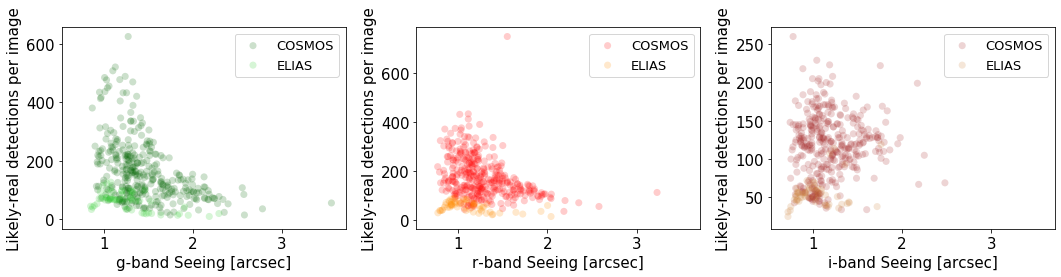

In [28]:
# Plotting it all up
fig, ax = plt.subplots(1,3, figsize=(figwidth, figheight), sharex=True)
ax[0].xaxis.set_tick_params(which='both', labelbottom=True)
ax[1].xaxis.set_tick_params(which='both', labelbottom=True)

ax[0].scatter( gsee, opig_see, color='darkgreen', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[0].scatter( Egsee, Eopig_see, color='limegreen', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[1].scatter( rsee, opir_see, color='red', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[1].scatter( Ersee, Eopir_see, color='darkorange', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[2].scatter( isee, opii_see, color='brown', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[2].scatter( Eisee, Eopii_see, color='peru', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[0].set_xlabel( 'g-band Seeing [arcsec]' )
ax[0].set_ylabel( 'Likely-real detections per image' )
ax[0].legend(fontsize=lfs)
ax[1].set_xlabel( 'r-band Seeing [arcsec]' )
ax[1].set_ylabel( 'Likely-real detections per image' )
ax[1].legend(fontsize=lfs)
ax[2].set_xlabel( 'i-band Seeing [arcsec]' )
ax[2].set_ylabel( 'Likely-real detections per image' )
ax[2].legend(fontsize=lfs)
fig.tight_layout()
plt.savefig("./images/seeingVopi_COSMOS");

#### Limiting magnitude v OPI (COSMOS & ELIAS)

In [29]:
query = ( 'SELECT o.id, e.filename, s.lmt_mg, e.filter, e.id, e.mjd, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

lmtmgquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.id, e.filename, s.lmt_mg, e.filter, e.id, e.mjd, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

Elmtmgquery = np.array( cursor.fetchall() ).transpose()

In [30]:
lmtmgquery = rm_dupes(lmtmgquery,0)
Elmtmgquery = rm_dupes(Elmtmgquery,0)

2002 duplicates removed
18 duplicates removed


In [31]:
fnms = np.array(lmtmgquery[1], dtype=str)
lmt_mg = lmtmgquery[2].astype(np.float)

fnms_unique, indices, opi = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)

# Find the average magzp for each exposure
lmt_mg_med = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    lmt_mg_med[i] = np.median( lmt_mg[msk] )

In [32]:
filters = lmtmgquery[3][indices]

In [33]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [34]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
lmt_mg_med = lmt_mg_med[grimsk]
opi = opi[grimsk]
filters = filters[grimsk]

In [35]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

glmt_mg_med, opig_lmt_mg = lmt_mg_med[gmsk], opi[gmsk]
rlmt_mg_med, opir_lmt_mg = lmt_mg_med[rmsk], opi[rmsk]
ilmt_mg_med, opii_lmt_mg = lmt_mg_med[imsk], opi[imsk]

In [36]:
fnms = np.array(Elmtmgquery[1], dtype=str)
lmt_mg = Elmtmgquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
fnms_unique, indices, opi = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)
# Find the average magzp for each exposure
lmt_mg_med = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    lmt_mg_med[i] = np.median( lmt_mg[msk] )

In [37]:
filters = Elmtmgquery[3][indices]

In [38]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [39]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
lmt_mg_med = lmt_mg_med[grimsk]
opi = opi[grimsk]
filters = filters[grimsk]

In [40]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

Eglmt_mg_med, Eopig_lmt_mg = lmt_mg_med[gmsk], opi[gmsk]
Erlmt_mg_med, Eopir_lmt_mg = lmt_mg_med[rmsk], opi[rmsk]
Eilmt_mg_med, Eopii_lmt_mg = lmt_mg_med[imsk], opi[imsk]

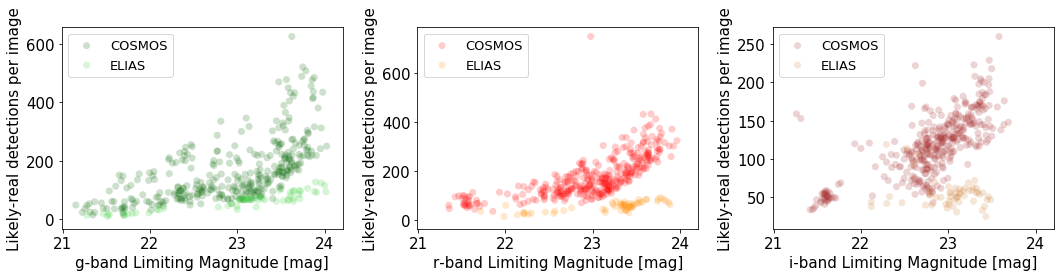

In [41]:
# Plotting it all up
fig, ax = plt.subplots(1,3, figsize=(figwidth, figheight), sharex=True)


ax[0].scatter( glmt_mg_med, opig_lmt_mg, color='darkgreen', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[0].scatter( Eglmt_mg_med, Eopig_lmt_mg, color='limegreen', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[0].set_xlabel( 'g-band Limiting Magnitude [mag]' )

ax[1].scatter( rlmt_mg_med, opir_lmt_mg, color='red', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[1].scatter( Erlmt_mg_med, Eopir_lmt_mg, color='darkorange', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[1].set_xlabel( 'r-band Limiting Magnitude [mag]' )

ax[2].scatter( ilmt_mg_med, opii_lmt_mg, color='brown', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[2].scatter( Eilmt_mg_med, Eopii_lmt_mg, color='peru', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[2].set_xlabel( 'i-band Limiting Magnitude [mag]' )

for i in ax:
    i.xaxis.set_tick_params(which='both', labelbottom=True)
    i.set_ylabel( 'Likely-real detections per image' )
    i.legend(fontsize=lfs)
fig.tight_layout()
plt.savefig("./images/lmtmgVopi_COSMOS");

#### Skysig v OPI (COSMOS & ELIAS)

In [42]:
query = ( 'SELECT o.id, e.filename, s.skysig, e.filter, e.id, e.mjd, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

skysigquery = np.array( cursor.fetchall() ).transpose()

query = ( 'SELECT o.id, e.filename, s.skysig, e.filter, e.id, e.mjd, o.candidate_id, o.rb FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,8.5,-43.5,3) '
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

Eskysigquery = np.array( cursor.fetchall() ).transpose()

In [43]:
skysigquery = rm_dupes(skysigquery,0)
Eskysigquery = rm_dupes(Eskysigquery,0)

2002 duplicates removed
18 duplicates removed


In [44]:
fnms = np.array(skysigquery[1], dtype=str)
skysig = skysigquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
fnms_unique, indices, opi = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)
# Find the average magzp for each exposure
logskysig_med = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    logskysig_med[i] = np.log10( np.median( skysig[msk] ) )

In [45]:
filters = skysigquery[3][indices]

In [46]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [47]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
logskysig_med = logskysig_med[grimsk]
opi = opi[grimsk]
filters = filters[grimsk]

In [48]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

glogskysig_med, opig_skysig = logskysig_med[gmsk], opi[gmsk]
rlogskysig_med, opir_skysig = logskysig_med[rmsk], opi[rmsk]
ilogskysig_med, opii_skysig = logskysig_med[imsk], opi[imsk]

In [49]:
fnms = np.array(Eskysigquery[1], dtype=str)
skysig = Eskysigquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
fnms_unique, indices, opi = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)
# Find the average magzp for each exposure
logskysig_med = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    logskysig_med[i] = np.log10( np.median( skysig[msk] ) )

In [50]:
filters = Eskysigquery[3][indices]

In [51]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [52]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
logskysig_med = logskysig_med[grimsk]
opi = opi[grimsk]
filters = filters[grimsk]

In [53]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

Eglogskysig_med, Eopig_skysig = logskysig_med[gmsk], opi[gmsk]
Erlogskysig_med, Eopir_skysig = logskysig_med[rmsk], opi[rmsk]
Eilogskysig_med, Eopii_skysig = logskysig_med[imsk], opi[imsk]

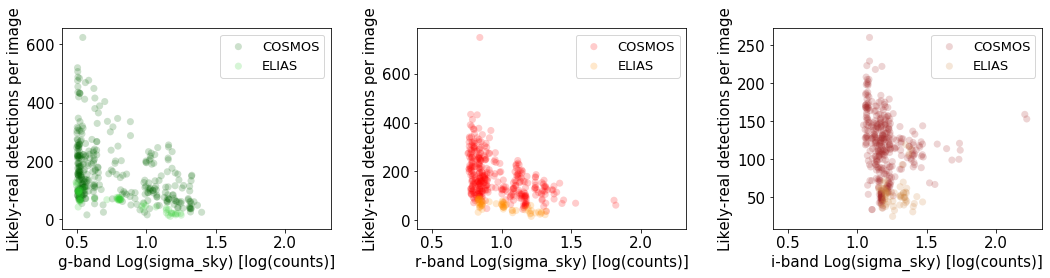

In [54]:
# Plotting it all up
fig, ax = plt.subplots(1,3, figsize=(figwidth, figheight), sharex=True)


ax[0].scatter( glogskysig_med, opig_skysig, color='darkgreen', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[0].scatter( Eglogskysig_med, Eopig_skysig, color='limegreen', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[0].set_xlabel( 'g-band Log(sigma_sky) [log(counts)]' )

ax[1].scatter( rlogskysig_med, opir_skysig, color='red', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[1].scatter( Erlogskysig_med, Eopir_skysig, color='darkorange', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[1].set_xlabel( 'r-band Log(sigma_sky) [log(counts)]' )

ax[2].scatter( ilogskysig_med, opii_skysig, color='brown', label='COSMOS', s=dotsize, alpha=a, edgecolors='none')
ax[2].scatter( Eilogskysig_med, Eopii_skysig, color='peru', label='ELIAS', s=dotsize, alpha=a, edgecolors='none')
ax[2].set_xlabel( 'i-band Log(sigma_sky) [log(counts)]' )

for i in ax:
    i.xaxis.set_tick_params(which='both', labelbottom=True)
    i.set_ylabel( 'Likely-real detections per image' )
    i.legend(fontsize=lfs)

fig.tight_layout()
plt.savefig("./images/logskysigVopi_COSMOS");

# No longer useful

#### How does median pixel value affect number of good detections? (uses lookup table 'medpixval.txt') (COSMOS)

In [55]:
query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

pixvalquery = np.array( cursor.fetchall() ).transpose()

In [56]:
# truncate filenames to match lookup table format
fnms = [pixvalquery[1][i][:21] for i in range(len(pixvalquery[1]))]

# count the number of objects in each image (obsperimg) and create a mask to select the data for each of those exposures only once (index)
cands, index, objsperimg = np.unique(pixvalquery[1], return_index=True, return_counts=True)

# load in the lookup table
pixvallt = np.loadtxt("medpixval.txt", dtype=np.str).transpose()

# resize the filename array to only look at each exposure once (i.e. not once for every object in it)
fnms = np.array(fnms)[index]

# create an array of mmedian pixel values by matching the filenames in the query result to the filenames in the lookup table 
pixval = np.ones(len(fnms))
for i in range(len(fnms)):
    pixval[i] = pixvallt[1][np.where(fnms[i] == pixvallt[0])[0]]

In [57]:
# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [58]:
# Eliminate objects from non-standard images
filters = np.array( pixvalquery[2] )[index]

gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
filters = filters[grimsk]
pixval = pixval[grimsk]
objsperimg = objsperimg[grimsk]

In [59]:
# Create masks for different filters
gmsk = np.where(filters=='g')[0]
rmsk = np.where(filters=='r')[0]
imsk = np.where(filters=='i')[0]

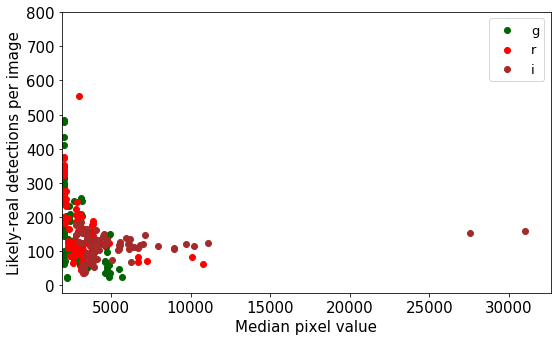

In [60]:
# Plotting it up
plt.figure(figsize=(8,5))
plt.scatter(pixval[gmsk], objsperimg[gmsk], color='darkgreen', label='g')
plt.scatter(pixval[rmsk], objsperimg[rmsk], color='red', label='r')
plt.scatter(pixval[imsk], objsperimg[imsk], color='brown', label='i')
plt.xlim(1920, )
plt.xlabel('Median pixel value')
plt.ylabel('Likely-real detections per image')
plt.legend(fontsize=lfs)
plt.tight_layout()
plt.savefig("./images/medpixvalVopi_COSMOS");

#### How does the distance to the moon affect the number of good detections? (COSMOS)

In [61]:
query = ( 'SELECT o.id, e.filename, e.mjd, e.ra, e.dec, e.filter FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb > 0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

moonquery = np.array( cursor.fetchall() ).transpose()

In [62]:
# Counting the number of objects in each exposure (objs) and masking the dates, filters, and coordinates to match
exps, indices, objs = np.unique( moonquery[1], return_counts=True, return_index=True )
mjds = moonquery[2][indices].astype(np.float)
filters = moonquery[5][indices]
obs_coords = GCRS( ra = moonquery[3][indices].astype(np.float)*u.deg, dec = moonquery[4][indices].astype(np.float)*u.deg, representation_type=None )

# Putting it into a Pandas DataFrame to keep better track of what is what
moon_df = pd.DataFrame(np.array([exps,objs,filters,mjds, obs_coords]).transpose(), columns = ['Fnm', 'Objs', 'Filter', 'MJD', 'ObsCoords'])

In [63]:
# Calculate the Moon's coordinates at the time of observation and put them into a new column
moon_df['MJD'] = [Time(i, format='mjd') for i in moon_df['MJD']]
moon_df["MoonCoords"] = [get_moon(i) for i in moon_df['MJD']]

In [64]:
# Calculate the great circle distance separation between the observation and the Moon and put it in a new column
moon_df['MoonSep'] = [moon_df['ObsCoords'][i].separation(moon_df['MoonCoords'][i]) for i in range(len(moon_df['Fnm']))]
moon_df['MoonSep'] = [i.value for i in moon_df['MoonSep']]

In [65]:
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)
fnms = [exps[i][:21] for i in range(len(exps))] # truncate filenames to match lookup table format

In [66]:
# find the exposure time for each object
moon_df["Exptime"] = np.array([exptable[np.where(fnms[i] == fnmtable)[0]][0] for i in range(len(fnms))], dtype=float)

In [67]:
# Eliminate objects from non-standard images
gmsk = np.where((moon_df["Filter"]=="g") & (moon_df["Exptime"]>50))[0]
rmsk = np.where((moon_df["Filter"]=="r") & (moon_df["Exptime"]>20))[0]
imsk = np.where((moon_df["Filter"]=="i") & (moon_df["Exptime"]>20))[0]
grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)
len(grimsk)
# apply the standard images mask
for i in moon_df:
    moon_df[i] = moon_df[i][grimsk]

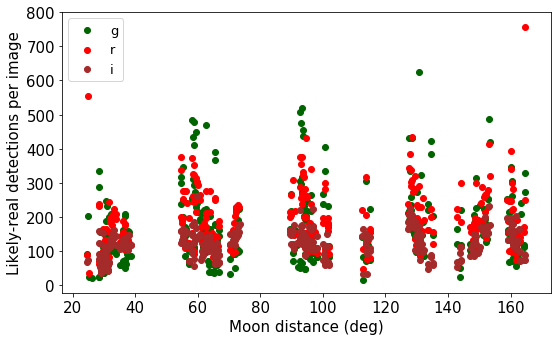

In [68]:
# Create masks for different filters
gmsk = np.where(moon_df["Filter"]=='g')[0]
rmsk = np.where(moon_df["Filter"]=='r')[0]
imsk = np.where(moon_df["Filter"]=='i')[0]

# Plot
plt.figure(figsize=(8,5))
plt.scatter(moon_df['MoonSep'][gmsk], moon_df['Objs'][gmsk], color='darkgreen', label='g')
plt.scatter(moon_df['MoonSep'][rmsk], moon_df['Objs'][rmsk], color='red', label='r')
plt.scatter(moon_df['MoonSep'][imsk], moon_df['Objs'][imsk], color='brown', label='i')
plt.xlabel('Moon distance (deg)')
plt.ylabel('Likely-real detections per image')
plt.legend(fontsize=lfs)
plt.tight_layout()
plt.savefig("./images/moondistVopi_COSMOS");

#### How does the distance to the moon affect the number of good detections? (COSMOS) (This section uses the 'moondata.txt' lookup table but gets the same result as above, so I have it commented out)

In [69]:
# query = ( 'SELECT o.candidate_id, e.filename, e.filter FROM objects o '
#          'JOIN subtractions s ON o.subtraction_id=s.id '
#          'JOIN exposures e ON e.id=s.exposure_id '
#          'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
#          'AND o.rb>0.6 '
#          'LIMIT 10000000' )

# cursor.execute( query )

# moonquery2 = np.array( cursor.fetchall() ).transpose()

In [70]:
# fnms = [moonquery2[1][i][:21] for i in range(len(moonquery2[1]))] # truncate filenames to match lookup table format
# cands, index, objsperimg = np.unique(moonquery2[1], return_index=True, return_counts=True)
# table = np.loadtxt("moondata.txt", dtype=np.str).transpose()
# fnms = np.array(fnms)[index]
# moondist = np.ones(len(fnms))
# for i in range(len(fnms)):
#     moondist[i] = table[1][np.where(fnms[i] == table[0])[0]]

In [71]:
# # Create masks for different filters
# gmsk = np.where(moonquery2[2][index]=='g')[0]
# rmsk = np.where(moonquery2[2][index]=='r')[0]
# imsk = np.where(moonquery2[2][index]=='i')[0]

In [72]:
# # Plotting it all up, looks the same as before

# plt.figure(figsize=(8,5))
# plt.scatter(moondist[gmsk], objsperimg[gmsk], color='g', label='g')
# plt.scatter(moondist[rmsk], objsperimg[rmsk], color='r', label='r')
# plt.scatter(moondist[imsk], objsperimg[imsk], color='b', label='i')
# plt.xlabel('Moon distance (deg)')
# plt.ylabel('Likely-real detections per image')
# plt.legend(fontsize=lfs);

#### How does magzp affect number of good detections? (COSMOS)

In [73]:
query = ( 'SELECT o.id, e.filename, s.magzp, e.filter, e.id, e.mjd FROM objects o '
         'JOIN subtractions s ON o.subtraction_id=s.id '
         'JOIN exposures e ON e.id=s.exposure_id '
         'WHERE q3c_radial_query(o.ra,o.dec,150,2.2,3) ' 
         'AND o.rb>0.6 '
         'LIMIT 10000000' )

cursor.execute( query )

magzpquery = np.array( cursor.fetchall() ).transpose()

In [74]:
fnms = np.array(magzpquery[1], dtype=str)
magzp = magzpquery[2].astype(np.float)

# Determine which exposure IDs are present
# expids_unique = np.unique(expids)
fnms_unique, indices, objperimg = np.unique( fnms, return_counts=True, return_index=True )
fnms_unique = fnms_unique.astype(str)
# Find the average magzp for each exposure
magzpav = np.zeros(len(fnms_unique))
for i in range(len(fnms_unique)):
    msk = np.where( fnms == fnms_unique[i] )[0]
    magzpav[i] = np.median( magzp[msk] )

# magzp = np.array( [np.median( magzp[np.where( fnms == i )[0]] ) for i in fnms_unique.astype(str)] )

In [75]:
len(magzp)

166483

In [76]:
# determine how many objects are in each exposure, and create an array of filters resized in the same way
# exp, indices, objperimg = np.unique( expids, return_counts=True, return_index=True )
filters = magzpquery[3][indices]

In [77]:
# truncate filenames to match lookup table format
fnms_unique = [fnms_unique[i][:21] for i in range(len(fnms_unique))]

# read in the exposure time lookup table
lutable = np.loadtxt("archive_image_list.txt", dtype=object).transpose()
fnmtable, exptable = lutable[0], lutable[7].astype(float)

# find the exposure time for each object
exptimes = np.array([exptable[np.where(fnms_unique[i] == fnmtable)[0]][0] for i in range(len(fnms_unique))], dtype=float)

In [78]:
# Eliminate objects from non-standard images
gmsk = np.where((filters=="g") & (exptimes>50))[0]
rmsk = np.where((filters=="r") & (exptimes>20))[0]
imsk = np.where((filters=="i") & (exptimes>20))[0]

grmsk = np.append(rmsk, gmsk)
grimsk = np.append(grmsk, imsk)

# apply the standard images mask
magzpav = magzpav[grimsk]
objperimg = objperimg[grimsk]
filters = filters[grimsk]

In [79]:
# Creating masks for each filter
gmsk = np.where( filters == 'g' )[0]
rmsk = np.where( filters == 'r' )[0]
imsk = np.where( filters == 'i' )[0]

gmagzpav, opig_magzp = magzpav[gmsk], objperimg[gmsk]
rmagzpav, opir_magzp = magzpav[rmsk], objperimg[rmsk]
imagzpav, opii_magzp = magzpav[imsk], objperimg[imsk]

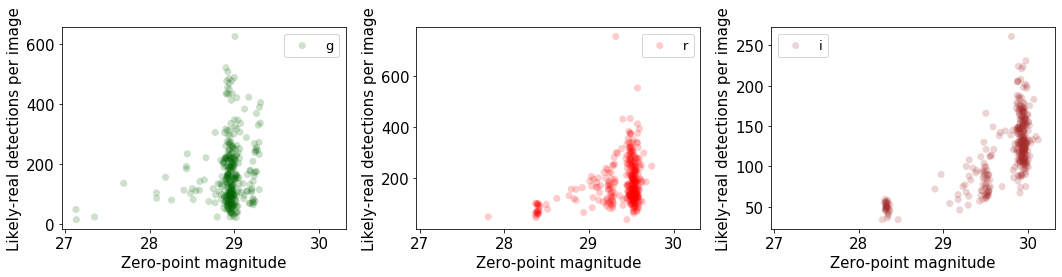

In [80]:
# Plotting it all up
fig, ax = plt.subplots(1,3, figsize=(figwidth, figheight), sharex=True)


ax[0].scatter( gmagzpav, opig_magzp, color='darkgreen', label='g', s=dotsize, alpha=a, edgecolors='none')
ax[1].scatter( rmagzpav, opir_magzp, color='red', label='r', s=dotsize, alpha=a, edgecolors='none')
ax[2].scatter( imagzpav, opii_magzp, color='brown', label='i', s=dotsize, alpha=a, edgecolors='none')
for i in ax:
    i.xaxis.set_tick_params(which='both', labelbottom=True)
    i.set_xlabel( 'Zero-point magnitude')
    i.set_ylabel( 'Likely-real detections per image' )
    i.legend(fontsize=lfs)
fig.tight_layout()
plt.savefig("./images/magzpVopi_COSMOS");